In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import random

from sklearn.linear_model import LinearRegression
from snp500 import SNP500
from tqdm.auto import tqdm
from pprint import pprint

from workflow.tools.utils import set_plot_style

set_plot_style()

In [2]:
random.seed(42)

kwargs = {
    "index_col": 0,
    "parse_dates": True
}

# Load in prices
stock_prices = pd.read_csv("workflow/data/constituents.csv", **kwargs)
index_prices = pd.read_csv("workflow/data/indices.csv", **kwargs)

all_stocks = stock_prices.columns.to_list()
indices = index_prices.columns.to_list()

pct = .02
stocks = random.sample(all_stocks, int(len(all_stocks)*pct))
stock_prices = stock_prices[stocks]

stock_rets = np.log(stock_prices).diff()[1:]
index_rets = np.log(index_prices).diff()[1:]

print(stock_prices.shape, index_prices.shape)

(1232, 9) (1232, 4)


In [3]:
stocks

['NWS', 'BF-B', 'AEP', 'ROK', 'DXCM', 'DFS', 'CTAS', 'BX', 'RL']

In [4]:
window = 60
reversion_window = 30
trading_days = 252

dates = stock_rets.index[window:]

betas = pd.DataFrame(columns=stocks, index=dates)
s_scores = betas.copy()

for date in tqdm(dates):
    Rm = index_rets.loc[:date][-window:].values
    Rm = (Rm - np.mean(Rm)) / np.std(Rm)
    Rs = stock_rets.loc[:date][-window:]

    ou_params = pd.DataFrame(
        columns=["a", "b", "var(z)", "m", "sigma_eq"],
        index=stocks,
    )

    for stock in stocks:
        Ri = Rs[stock].values
        lr_1 = LinearRegression().fit(Rm, Ri)

        B = lr_1.coef_
        betas.loc[date, stock] = B
        e = Ri - lr_1.predict(Rm)

        E = e.cumsum()
        E0 = E[:-1].reshape(-1, 1)
        E1 = E[1:]
        lr_2 = LinearRegression().fit(E0, E1)

        a = lr_2.intercept_
        b = lr_2.coef_
        var_z = np.var(E1 - lr_2.predict(E0))
        k = -np.log(b) * trading_days

        if k > trading_days / reversion_window:
            m = a / (1 - b)
            sigma_eq = np.sqrt(var_z / (1 - b**2))
            ou_params.loc[stock] = [i.item() for i in [a, b, var_z, m, sigma_eq]]
        
    ou_params.dropna(inplace=True)
    m_bar = (ou_params["a"] / (1 - ou_params["b"])) - \
        (np.mean(ou_params["a"]) / (1 - np.mean(ou_params["b"])))
    
    s = -m_bar / ou_params["sigma_eq"]
    s_scores.loc[date] = s

  0%|          | 0/1171 [00:00<?, ?it/s]

In [5]:
# fig, axes = plt.subplots(3, 3, figsize=(7, 5), sharex=True)
# axes = axes.flatten()

# for i, stock in enumerate(stocks):
#     ax = axes[i]
#     axtwin = ax.twinx()
#     s = s_scores[stock][int(-window*1.5):]
#     p = stock_prices[stock][int(-window*1.5):]
#     s.plot(ax=ax, grid=False)
#     p.plot(ax=axtwin, grid=False, linestyle="--", alpha=.5)
#     ax.axhline(1.25, color="r", linewidth=.3)
#     ax.axhline(0, color="k", linewidth=.3)
#     ax.axhline(-1.25, color="g", linewidth=.3)
#     ax.set_xlabel("")
#     ax.set_title(stock)
#     axtwin.set_yticks([])
#     ax.set_xticks([])

# plt.tight_layout()
# plt.show()

In [6]:
signals = pd.DataFrame(columns=stocks, index=dates)

for stock in tqdm(stocks):
    position = 0
    stock_positions = []

    for date in dates:
        s = s_scores.loc[date, stock]

        if s >= 1.25:
            position = -1
            stock_positions.append(position)
        elif s <= -1.25:
            position = 1
            stock_positions.append(position)
        elif s >= -0.5 and position == 1:
            position = 0
            stock_positions.append(position)
        elif s <= 0.75 and position == -1:
            position = 0
            stock_positions.append(position)
        else:
            stock_positions.append(position)
        
    signals[stock] = stock_positions

  0%|          | 0/9 [00:00<?, ?it/s]

In [7]:
weights = signals.copy()

for date in dates:
    w = weights.loc[date].copy()
    w[w > 0] /= sum(w > 0)
    w[w < 0] /= sum(w < 0)
    weights.loc[date] = w
    
weights = weights.shift()[1:]

weights[indices] = -np.stack((betas.shift()[1:] * weights).sum(axis=1).values)

weights.head()

,NWS,BF-B,AEP,ROK,DXCM,DFS,CTAS,BX,RL,AGG,DBC,^GSPC,^VIX
Date,,,,,,,,,,,,,
2019-04-02,0.0,-0.5,0.0,0.0,1.0,-0.5,0.0,0.0,0.0,0.091900,-0.007805,-0.012410,-0.001201
2019-04-03,0.0,-0.5,0.0,0.0,1.0,-0.5,0.0,0.0,0.0,0.086736,-0.007248,-0.021353,-0.001479
2019-04-04,0.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.103845,-0.002095,-0.015922,-0.000038
2019-04-05,0.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.103326,-0.001848,-0.015480,-0.000020
2019-04-08,0.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.106145,0.018104,-0.021232,0.000152


<Axes: xlabel='Date'>

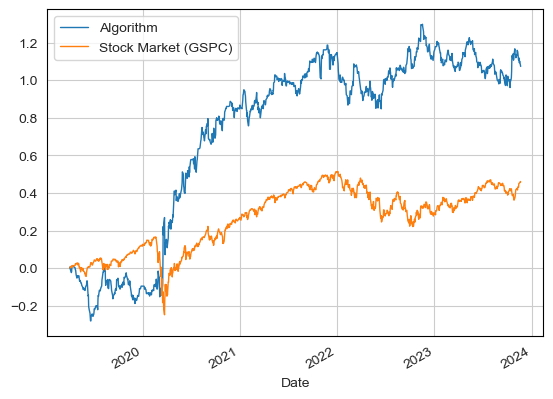

In [8]:
asset_rets = pd.concat([stock_rets, index_rets], axis=1)

algo_rets = (asset_rets[window+1:] * weights).sum(axis=1)
benchmark_rets = asset_rets["^GSPC"][window+1:]

backtest_rets = pd.concat([algo_rets, benchmark_rets], axis=1)
backtest_rets.columns=["Algorithm", "Stock Market (GSPC)"]
backtest_rets.loc[backtest_rets.index.min()] = 0

backtest_rets.cumsum().plot()

In [9]:
(abs(weights).sum(axis=1) / 2).isnull().sum()

0